# L2 正则化

## 高维线性回归

通过一个简单的例子来演示 L2 正则化。

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据
生成公式为：$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.01^2$
选择标签是关于输入的线性函数，标签同时被均值为 0，标准差为 0.01 高斯噪声污染。
为了使过拟合的效果更加明显，将问题的维数增加到 $d=200$，并使用一个只包含 20 个样本的小训练集。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从零开始实现

将 $L_2$ 的平方惩罚添加到原始目标函数中。

### 参数初始化


In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 损失函数定义：平方和

损失函数是是对所有项求平方后并将它们求和。

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 训练

训练模型，唯一的变化是损失现在包括了惩罚项。

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 忽略正则化直接训练

现在用 `lambd = 0` 禁用正则化后运行这个代码。
其结果是，训练误差有了减少，但测试误差没有减少，这意味着出现了严重的过拟合。

w的L2范数是： 12.5608549118042


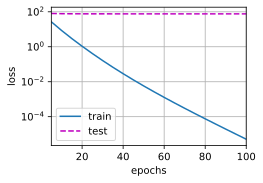

In [6]:
train(lambd=0)

### 使用正则化巡礼

其结果是，训练误差增大，但测试误差减小，这正是 ML 期望从正则化中得到的效果。

w的L2范数是： 0.315790057182312


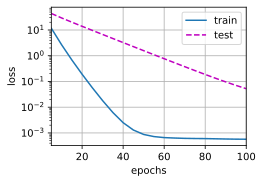

In [7]:
train(lambd=3)

## 简洁实现

由于正则化在神经网络优化中很常用，深度学习框架为了便于使用，将正则化集成到优化算法中，以便与任何损失函数结合使用。
此外，这种集成还有计算上的好处，允许在不增加任何额外的计算开销的情况下向算法中添加正则化。
由于更新的正则化仅依赖于每个参数的当前值，因此优化器必须至少接触每个参数一次。

在下面的代码中，在实例化优化器时直接通过 `weight_decay` 指定 weight decay 超参数。
默认情况下，PyTorch 同时衰减权重和偏移，这里我们只为权重设置了 `weight_decay`，所以偏置参数 $b$ 不会衰减。

In [8]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='mean')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

它们运行得更快，更容易实现，对于更复杂的问题，这一好处将变得更加明显。

w的L2范数： 12.93627643585205


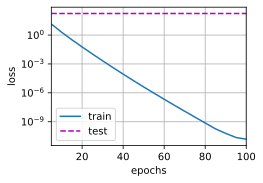

In [9]:
train_concise(0)

w的L2范数： 0.41888758540153503


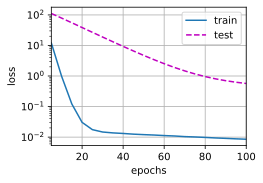

In [10]:
train_concise(3)